In [493]:
import pandas as pd
import numpy as np

In [494]:
data=pd.read_excel('118Busdata.xlsx',sheet_name='lines')

In [495]:
fb=data.iloc[0:,1].values
tb=data.iloc[0:,2].values
angle=data.iloc[0:118,10].values
X=data.iloc[0:,4].values

In [496]:
import numpy as np
c=np.array([np.zeros(fb.shape[0]) for i in range (tb.shape[0])])
for i in range (fb.shape[0]):
    for j in range (fb.shape[0]):
        if(i==j):
           c[i][j]=-1/X[j]
inc=np.array([np.zeros(fb.shape[0]) for i in range (angle.shape[0])])

for i in range (angle.shape[0]):
    for j in range (fb.shape[0]):
        if (fb[j]==i+1):
            inc[i][j]=-1
        if (tb[j]==i+1):
            inc[i][j]=1  

In [497]:
Y_bus=np.dot(inc,np.dot(c,inc.T))

In [498]:
P_bus=data.iloc[0:118,9].values

In [499]:
np.dot(Y_bus,(angle*3.14/180).reshape(118,1))

array([[ 5.09741452e-01],
       [ 1.99898609e-01],
       [ 3.89802287e-01],
       [ 3.89802287e-01],
       [-5.06045070e-02],
       [ 5.19736382e-01],
       [ 1.89903678e-01],
       [ 3.30462559e-01],
       [-1.06581410e-14],
       [-4.49771869e+00],
       [ 6.99645130e-01],
       [-3.79807356e-01],
       [ 3.39827634e-01],
       [ 1.39929026e-01],
       [ 8.99543738e-01],
       [ 2.49873261e-01],
       [ 1.83521802e-02],
       [ 5.99695826e-01],
       [ 4.49771869e-01],
       [ 1.79908748e-01],
       [ 1.39929026e-01],
       [ 9.99493043e-02],
       [ 6.99645130e-02],
       [ 1.29934096e-01],
       [-2.23439526e+00],
       [-3.10289759e+00],
       [ 7.09640060e-01],
       [ 1.69913817e-01],
       [ 2.39878330e-01],
       [ 9.15920545e-02],
       [ 3.59817495e-01],
       [ 5.89700895e-01],
       [ 2.29883400e-01],
       [ 5.89700895e-01],
       [ 3.29832704e-01],
       [ 3.09842843e-01],
       [-1.57590790e-01],
       [ 1.57590790e-01],
       [ 2.6

## OPtimal PMU placement

## The PMU placement concept is simply explained as follows: If a bus or at leastone of its adjacent buses is equipped with PMU then this bus is observable. Onetrivial solution for PMU placement problem is installing PMU at all buses. Thissolution makes all buses observable but obviously the costs would be very high andsometimes practical aspects do not allow this to happen. In other words, it is triedto find the minimum number of buses to have PMU devices in order to make thewhole system observable

In [500]:
Y_norm=np.dot(np.diag(1/np.sqrt(np.diag(-Y_bus))),np.dot(Y_bus,np.diag(np.sqrt(1/np.diag(-Y_bus)))))

In [501]:
Adj=Y_norm-np.diag(np.diag(Y_norm))

In [502]:
A=Adj
for i in range (Y_norm.shape[0]):
    for j in range (Y_norm.shape[0]):
        if (Adj[i][j]>0):
            A[i][j]=1
        else:
            A[i][j]=0

In [503]:
X=np.ones(Y_norm.shape[0])

In [504]:
np.multiply(A[0],X)

array([0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Objective function for optimal pmu placement

Min $\sum(Y_{i})$

S.T $Y_{i}+\sum_{i}(A_{i}Y)>1$ and $Y_{i}+\sum_{i}(A_{i}Y)<2$ here $A_{i}Y$ are element wise product

In [523]:
from gekko import GEKKO
m = GEKKO() # Initialize gekko
m.options.SOLVER=1  # APOPT is an MINLP solver

# optional solver settings with APOPT
m.solver_options = ['minlp_maximum_iterations 500', \
                    # minlp iterations with integer solution
                    'minlp_max_iter_with_int_sol 100', \
                    # treat minlp as nlp
                    'minlp_as_nlp 0', \
                    # nlp sub-problem max iterations
                    'nlp_maximum_iterations 500', \
                    # 1 = depth first, 2 = breadth first
                    'minlp_branch_method 1', \
                    # maximum deviation from whole number
                    'minlp_integer_tol 0.05', \
                    # covergence tolerance
                    'minlp_gap_tol 0.01']


# Integer constraints 
y=np.array([m.Var(value=1,lb=0,ub=1,integer=True)for i in range(Y_norm.shape[0])])

#y=m.Array(m.Var,(Y_norm.shape[0],1))

# Equations
eqn=np.array([np.sum(np.multiply(A,y)[i]) for i in range (Y_norm.shape[0])])
for i in range (Y_norm.shape[0]):
    m.Equation(eqn[i]<2)
    m.Equation(eqn[i]>=1)
m.Obj(np.sum([y[i] for i in range (Y_norm.shape[0])])) # Objective
m.solve(disp=True) # Solve
print('Results')
print([y[i][0] for i in range (Y_norm.shape[0])])
print('Objective: ' + str(m.options.objfcnval))
a=[]
for i in range (Y_norm.shape[0]):
    if(y[i][0]>0):
        a.append(i)
a=np.asarray(a)
print('\n optial pmu loc bus',a)

apm 103.115.195.69_gk_model64 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :          354
   Intermediates:            0
   Connections  :            0
   Equations    :          237
   Residuals    :          237
 
 Number of state variables:            354
 Number of total equations: -          236
 Number of slack variables: -          236
 ---------------------------------------
 Degrees of freedom       :           -118
 
 * Warning: DOF <= 0
 ----------------------------------------------
 Steady State Optimization with APOPT Solver
 ----------------------------------------------
Iter:     1 I:  0 Tm:      1.32 NLPi:    4 Dpth:    0 Lvs:    3 Obj:  4.15E+01 Gap:       NaN
Iter:     2 I: 

## Transmission outage model

In [365]:
!pip install gekko


  Stored in directory: C:\Users\NARESH RAM\AppData\Local\pip\Cache\wheels\5f\6d\c6\34a06c142314f690f6cf5d0ab2f8ae2dcf4fa29824db943127
Successfully built gekko
  Found existing installation: Werkzeug 0.14.1
    Uninstalling Werkzeug-0.14.1:
      Successfully uninstalled Werkzeug-0.14.1
  Found existing installation: Jinja2 2.10
    Uninstalling Jinja2-2.10:
      Successfully uninstalled Jinja2-2.10


hdijupyterutils 0.12.7 requires jupyter<2,>=1, which is not installed.
hdijupyterutils 0.12.7 requires nose, which is not installed.
hdijupyterutils 0.12.7 has requirement ipykernel<5,>=4.2.2, but you'll have ipykernel 5.1.0 which is incompatible.
hdijupyterutils 0.12.7 has requirement ipython<7,>=4.0.2, but you'll have ipython 7.4.0 which is incompatible.
autovizwidget 0.12.7 has requirement plotly<3.0,>=1.10.0, but you'll have plotly 3.9.0 which is incompatible.


In [448]:
from gekko import GEKKO
m = GEKKO() # Initialize gekko
m.options.SOLVER=1  # APOPT is an MINLP solver

# optional solver settings with APOPT
m.solver_options = ['minlp_maximum_iterations 500', \
                    # minlp iterations with integer solution
                    'minlp_max_iter_with_int_sol 10', \
                    # treat minlp as nlp
                    'minlp_as_nlp 0', \
                    # nlp sub-problem max iterations
                    'nlp_maximum_iterations 50', \
                    # 1 = depth first, 2 = breadth first
                    'minlp_branch_method 1', \
                    # maximum deviation from whole number
                    'minlp_integer_tol 0.05', \
                    # covergence tolerance
                    'minlp_gap_tol 0.01']

# Initialize variables
x1 = m.Var(value=1,lb=1,ub=5)
x2 = m.Var(value=5,lb=1,ub=5)
# Integer constraints for x3 and x4
y=[m.Var(value=5,lb=1,ub=5,integer=True) for n in range(2)]

#x4 = m.Var(value=1,lb=1,ub=5,integer=True)
# Equations
m.Equation(x1*x2*y[0]*y[1]>=25)
m.Equation(x1**2+x2**2+y[0]**2+y[1]**2==40)
m.Obj(x1*y[1]*(x1+x2+y[0])+y[0]) # Objective
m.solve(disp=False) # Solve
print('Results')
print('x1: ' + str(x1.value))
print('x2: ' + str(x2.value))
print('x3: ' + str(x3.value))
print('x4: ' + str(x4.value))
print('Objective: ' + str(m.options.objfcnval))

Results
x1: [1.3589086474]
x2: [4.5992789966]
x3: [4.0]
x4: [1.0]
Objective: 17.532267301


## ANN Bsed least square estimate

apm 103.115.195.69_gk_model50 <br><pre> ----------------------------------------------------------------
 APMonitor, Version 0.9.1
 APMonitor Optimization Suite
 ----------------------------------------------------------------
 
 
 --------- APM Model Size ------------
 Each time step contains
   Objects      :            0
   Constants    :            0
   Variables    :           21
   Intermediates:           14
   Connections  :            0
   Equations    :           15
   Residuals    :            1
 
 Number of state variables:             69
 Number of total equations: -           50
 Number of slack variables: -            0
 ---------------------------------------
 Degrees of freedom       :             19
 
 **********************************************
 Model Parameter Estimation with Interior Point Solver
 **********************************************
  
  
 Info: Exact Hessian

******************************************************************************
This program 

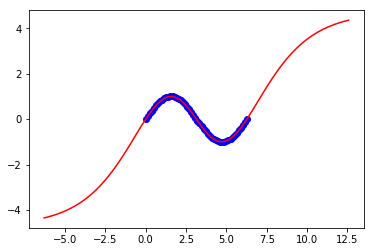

In [470]:
from gekko import brain
import numpy as np
import matplotlib.pyplot as plt  

# generate training data
x = np.linspace(0.0,2*np.pi)
y = np.sin(x)

b = brain.Brain()
b.input_layer(1)
b.layer(linear=2)
b.layer(tanh=2)
b.layer(linear=2)
b.output_layer(1)
# train
b.learn(x,y)      

# validate
xp = np.linspace(-2*np.pi,4*np.pi,100)
yp = b.think(xp)  

plt.figure()
plt.plot(x,y,'bo')
plt.plot(xp,yp[0],'r-')
plt.show()